In [1]:
import numpy as np
from astropy import coordinates as coo
from astropy import units as u
import healpy as hp
import matplotlib.pyplot as plt
import multiprocessing as mp
from astropy.io import fits
from data_process import jackknife_label, load_calculation_data, calculate_jackknife_variance_global

In [2]:
fwhm = 6

In [3]:
r_p, dat = load_calculation_data(f'../calculation_data/result_r=3_100_15_quasar_lss_all_CMB_smoothed_{fwhm}_tree.npy', return_rp=True)
dat_rw = load_calculation_data(f'../calculation_data/result_r=3_100_15_quasar_lss_reweight_CMB_smoothed_{fwhm}_tree.npy')
dat_h = load_calculation_data(f'../calculation_data/result_r=3_100_15_quasar_lss_high_L_CMB_smoothed_{fwhm}_tree.npy')
dat_l = load_calculation_data(f'../calculation_data/result_r=3_100_15_quasar_lss_low_L_CMB_smoothed_{fwhm}_tree.npy')
dat_r = load_calculation_data(f'../calculation_data/result_r=3_100_15_random_quasar_lss_all_CMB_smoothed_{fwhm}_tree.npy')

# with open('label.bin', 'rb') as f:
#     pix = np.load(f)
#     pix_r = np.load(f)

In [4]:
dat_zbin = [
    load_calculation_data(f'../calculation_data/result_r=3_100_15_quasar_lss_z{i}_CMB_smoothed_{fwhm}_tree.npy')
    for i in range(1, 4)
]

dat_r_zbin = [
    load_calculation_data(f'../calculation_data/result_r=3_100_15_random_z{i}_CMB_smoothed_{fwhm}_tree.npy')
    for i in range(1, 4)
]

In [5]:
Nside_jack = 10
quasar_cata = np.load('../catalogue/quasar_lss_all.npy')
random_sample = np.load('../catalogue/random_quasar_lss_all.npy')
quasar_rw = np.load('../catalogue/quasar_lss_reweight.npy')
quasar_h = np.load('../catalogue/quasar_lss_high_L.npy')
quasar_l = np.load('../catalogue/quasar_lss_low_L.npy')

quasar_zbin = [
    np.load(f'../catalogue/quasar_lss_z{i}.npy')
    for i in range(1, 4)
]

random_zbin = [
    np.load(f'../catalogue/random_z{i}.npy')
    for i in range(1, 4)
]

pix = jackknife_label(quasar_cata, Nside_jack)
pix_r = jackknife_label(random_sample, Nside_jack)
pix_l = jackknife_label(quasar_l, Nside_jack)
pix_h = jackknife_label(quasar_h, Nside_jack)

pix_zbin = [jackknife_label(q, Nside_jack) for q in quasar_zbin]
pix_r_zbin = [jackknife_label(q, Nside_jack) for q in random_zbin]

In [6]:
sampler_q = calculate_jackknife_variance_global(dat[0], dat[1], pix, dat_r[0], dat_r[1], pix_r, norm_cov=True)
sampler_h = calculate_jackknife_variance_global(dat_h[0], dat_h[1], pix_h, dat_r[0], dat_r[1], pix_r, norm_cov=True)
sampler_l = calculate_jackknife_variance_global(dat_l[0], dat_l[1], pix_l, dat_r[0], dat_r[1], pix_r, norm_cov=True)
# sampler_rw = calculate_jackknife_variance_global(dat_rw[0], dat_rw[1], pix, dat_r[0], dat_r[1], pix_r, norm_cov=True)

In [7]:
sampler_zbin = [
    calculate_jackknife_variance_global(
        dat_zbin[i][0], dat_zbin[i][1], pix_zbin[i], dat_r_zbin[i][0], dat_r_zbin[i][1], pix_r_zbin[i], norm_cov=True)
    for i in range(3)
]

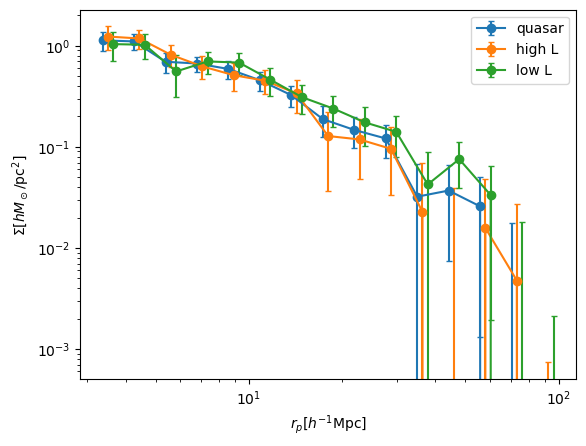

In [8]:
plt.errorbar(r_p, sampler_q['mean'], sampler_q['std'], capsize=2, fmt='-o', label='quasar')
plt.errorbar(r_p*1.04, sampler_l['mean'], sampler_l['std'], capsize=2, fmt='-o', label='high L')
plt.errorbar(r_p*1.04*1.04, sampler_h['mean'], sampler_h['std'], capsize=2, fmt='-o', label='low L')
# plt.errorbar(r_p, sampler_rw['mean'], sampler_rw['std'], capsize=2, fmt='-o', label='reweighting')
plt.ylabel(r'$\Sigma[h M_\odot /\mathrm{pc}^2]$')
plt.xlabel(r'$r_p[h^{-1}\mathrm{Mpc}]$')
plt.loglog()
plt.legend()

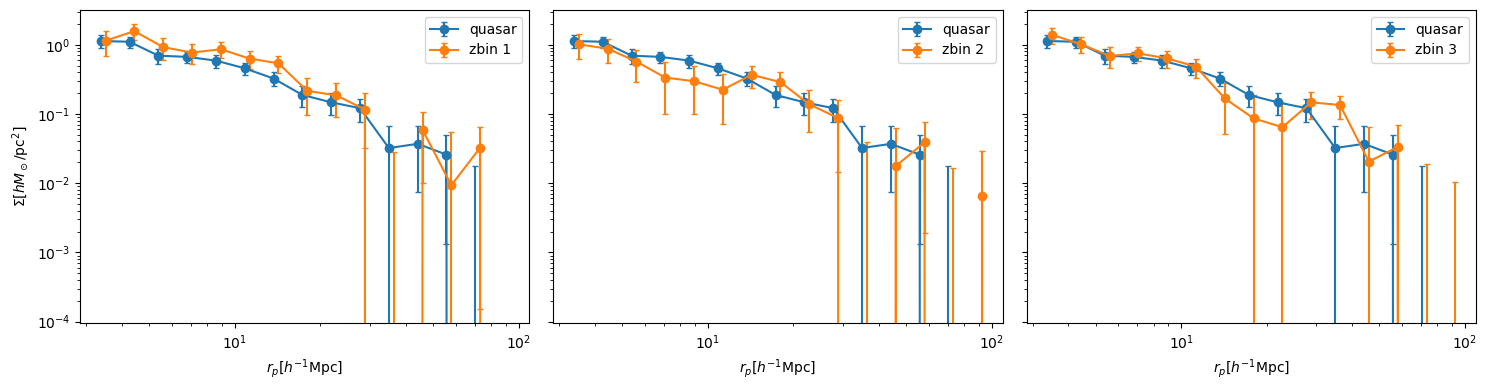

In [9]:
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(15, 4))
for i in range(3):
    axes[i].errorbar(r_p, sampler_q['mean'], sampler_q['std'], capsize=2, fmt='-o', label='quasar')
    axes[i].errorbar(r_p*1.04, sampler_zbin[i]['mean'], sampler_zbin[i]['std'], capsize=2, fmt='-o', label=f'zbin {i+1}')
    axes[i].set_xlabel(r'$r_p[h^{-1}\mathrm{Mpc}]$')
    axes[i].legend()
    axes[i].loglog()
axes[0].set_ylabel(r'$\Sigma[h M_\odot /\mathrm{pc}^2]$')
plt.tight_layout()

## plot covariance matrix(testing)

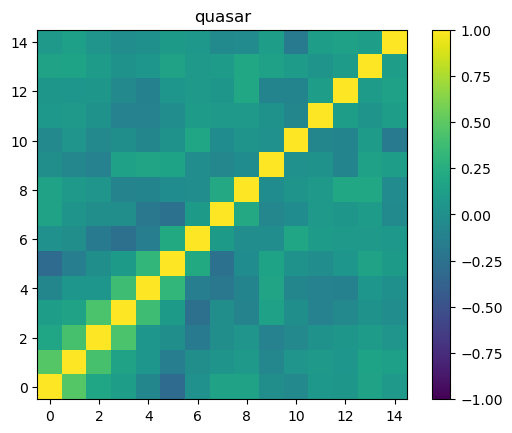

In [18]:
plt.imshow(sampler_q['cov'], origin='lower', vmin=-1, vmax=1)
plt.colorbar()
plt.title('quasar')
plt.show()

NameError: name 'savefig' is not defined

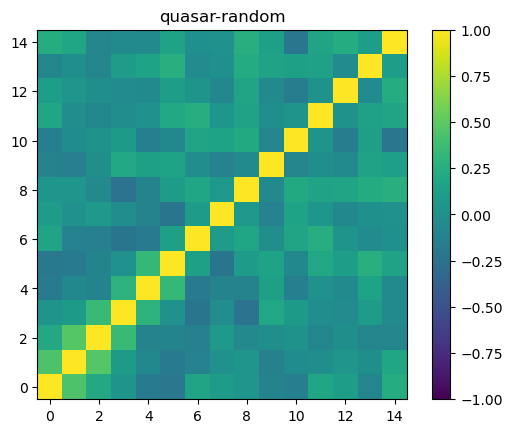

In [ ]:
sampler_sub = calculate_jackknife_variance_global(value, weight, pix, value_r, weight_r, pix_r, norm_cov=True, return_jackknife=True)
plt.imshow(sampler_sub['cov'], origin='lower', vmin=-1, vmax=1)
plt.title('quasar-random')
plt.colorbar()
plt.show()

In [ ]:
np.savetxt(f'./results/quasar_lss_all_cmb_smoothed_{fwhm}', np.c_[r_p, sampler_sub['mean'], sampler_sub['std']])

In [ ]:
np.save('cross_corr_jackknife_kmeans_100_new', sampler_sub['jackknife'])

## signal

In [ ]:
from astropy.cosmology import Planck18 as cosmos
h = cosmos.H0.value/100

In [ ]:
(200/2048)*60

5.859375

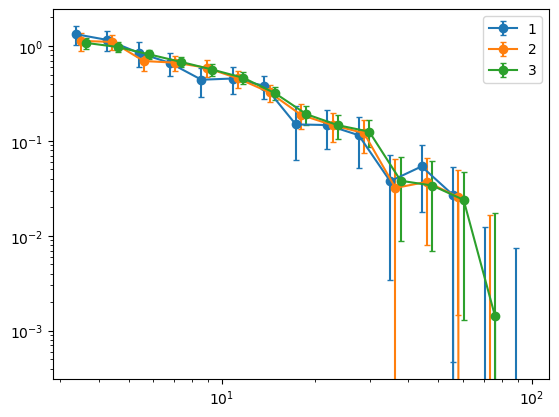

In [ ]:
res = np.loadtxt('./results/quasar_lss_all_cmb_lcut_2048')
res_2 = np.loadtxt('./results/quasar_lss_all_cmb_smoothed_6')
res_3 = np.loadtxt('./results/quasar_lss_all_cmb_smoothed_8')

r_p = res[:,0]
plt.errorbar(r_p, res[:,1], res[:,2], capsize=2, fmt='-o', label='1')
plt.errorbar(r_p*1.04, res_2[:,1], res_2[:,2], capsize=2, fmt='-o', label='2')
plt.errorbar(r_p*1.04, res_3[:,1], res_3[:,2], capsize=2, fmt='-o', label='3')
plt.loglog()
plt.legend()